In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "99"  # 设置log输出的信息，也就是程序运行时系统打印的信息

In [2]:
from tensorflow.python.client import device_lib   
device_lib.list_local_devices() # 查看设备信息

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14349501205929320609]

In [3]:
# Test with a simple computation
import tensorflow as tf

tf.Session()  # 创建会话

with tf.device('/cpu:0'):  # 使用cpu0
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])  # 初始化矩阵2*3
# If you have gpu you can try this line to compute b with your GPU
#with tf.device('/gpu:0'):    
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])  # 初始化矩阵3*2
c = tf.matmul(a, b) # 矩阵乘
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) 
# 创建会话，tf.ConfigProto(log_device_placement=True)可以获取到operations和tensor被指派到哪个设备上

print(sess.run(c)) # 运行上面的任务

# Runs the op.
# Log information
options = tf.RunOptions(output_partition_graphs=True) # 输出device信息
metadata = tf.RunMetadata()
c_val = sess.run(c, options=options, run_metadata=metadata)

print(metadata.partition_graphs)

sess.close()

[[22. 28.]
 [49. 64.]]
[node {
  name: "MatMul"
  op: "Const"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 2
          }
          dim {
            size: 2
          }
        }
        tensor_content: "\000\000\260A\000\000\340A\000\000DB\000\000\200B"
      }
    }
  }
}
node {
  name: "_retval_MatMul_0_0"
  op: "_Retval"
  input: "MatMul"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "index"
    value {
      i: 0
    }
  }
}
library {
}
versions {
  producer: 26
}
]


In [4]:
from __future__ import absolute_import # 绝对引入
from __future__ import division  # 精确除法
from __future__ import print_function # 强制按python3来写print()

import itertools # 迭代器

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams # plt参数配置
import matplotlib

from sklearn.model_selection import train_test_split # 分割训练集和测试集
from sklearn.preprocessing import MinMaxScaler # 归一化

tf.logging.set_verbosity(tf.logging.INFO) # 将tf日志信息输出到屏幕，可以选择日志级别
sess = tf.InteractiveSession()  # 创建会话

train = pd.read_csv('./train.csv')  # 读取训练集
print('Shape of the train data with all features:', train.shape) # 打印训练集大小
train = train.select_dtypes(exclude=['object']) # 根据数据类型获取列，这里选择数值类型的列
print("")
print('Shape of the train data with numerical features:', train.shape) # 打印数值特征大小
train.drop('Id',axis = 1, inplace = True) # 删除id列
train.fillna(0,inplace=True) # 用0填补缺失值

test = pd.read_csv('./test.csv') # 获取测试集
test = test.select_dtypes(exclude=['object']) # 获取测试集中的数值型特征
ID = test.Id # 获取id列
test.fillna(0,inplace=True) # 用0填补缺失值
test.drop('Id',axis = 1, inplace = True) # 删除id列

print("")
print("List of features contained our dataset:",list(train.columns))打印训练数据列名

Shape of the train data with all features: (1460, 81)

Shape of the train data with numerical features: (1460, 38)

List of features contained our dataset: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [5]:
from sklearn.ensemble import IsolationForest # 隔离森林，异常检测算法，叶子到根距离较短的可能就是异常点, 预测结果中+1表示正样本，-1表示负样本

clf = IsolationForest(max_samples = 100, random_state = 42) # 创建隔离森林模型
clf.fit(train) # 训练模型
y_noano = clf.predict(train) # 在训练集上进行预测
y_noano = pd.DataFrame(y_noano, columns = ['Top']) # 构造df,使用隔离森林的预测结果
y_noano[y_noano['Top'] == 1].index.values # 获取预测结果为1的行索引的数组

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values] # 获取预测结果为1的行，正样本
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0]) # 打印预测结果为-1的行数，即异常样本数
print("Number of rows without outliers:", train.shape[0]) # 正常样本数

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Number of Outliers: 146
Number of rows without outliers: 1314


In [6]:
train.head(10) # 打印正常样本的前10行

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
5,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,40,30,0,320,0,0,700,10,2009,143000
6,20,75.0,10084,8,5,2004,2005,186.0,1369,0,...,255,57,0,0,0,0,0,8,2007,307000
7,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,90,0,205,0,0,0,0,4,2008,129900
8,190,50.0,7420,5,6,1939,1950,0.0,851,0,...,0,4,0,0,0,0,0,1,2008,118000
9,20,70.0,11200,5,5,1965,1965,0.0,906,0,...,0,0,0,0,0,0,0,2,2008,129500


In [7]:
import warnings
warnings.filterwarnings('ignore') # 忽视warning信息

col_train = list(train.columns) # 获取训练集的列名
col_train_bis = list(train.columns) # 获取训练集的列名

col_train_bis.remove('SalePrice') # 删除label列

mat_train = np.matrix(train) # 创建训练数据的矩阵
mat_test  = np.matrix(test)  # 创建测试数据的矩阵
mat_new = np.matrix(train.drop('SalePrice',axis = 1)) # 创建不包含label的训练数据矩阵
mat_y = np.array(train.SalePrice).reshape((1314,1)) # 将训练数据的label从1*1314转成1314*1

prepro_y = MinMaxScaler() # 归一化
prepro_y.fit(mat_y)   # 对训练数据的label进行归一化

prepro = MinMaxScaler() # 归一化
prepro.fit(mat_train) 
# 对训练集features进行归一化，通过fit()找到数据的整体指标，如均值、方差、最大值最小值等，
#后面transform()就可以根据这些指标进行归一化处理

prepro_test = MinMaxScaler() # 归一化
prepro_test.fit(mat_new) # 对测试集features进行归一化

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train) # 对训练集features进行归一化，然后创建df,要先fit()，然后transform()
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis) # 对测试集features进行归一化

train.head() # 打印归一化后训练集的前几行

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.235294,0.207668,0.062802,0.625,0.428571,0.953488,0.883333,0.12250,0.416274,0.0,...,0.000000,0.167582,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.403057
1,0.000000,0.255591,0.072904,0.500,0.857143,0.744186,0.433333,0.00000,0.576651,0.0,...,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.340220
2,0.235294,0.217252,0.087396,0.625,0.428571,0.937984,0.866667,0.10125,0.286557,0.0,...,0.000000,0.115385,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.437966
3,0.294118,0.191693,0.072464,0.625,0.428571,0.271318,0.333333,0.00000,0.127358,0.0,...,0.000000,0.096154,0.824242,0.0,0.0,0.0,0.0,0.090909,0.00,0.243639
4,0.235294,0.268371,0.113835,0.750,0.428571,0.930233,0.833333,0.21875,0.386203,0.0,...,0.260870,0.230769,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.499638


In [8]:
# List of features
COLUMNS = col_train # 训练集列名
FEATURES = col_train_bis # 训练集列名，也就是features
LABEL = "SalePrice" # label, 目标值

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES] # 指定所有要素都有真实值

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]  # 训练集features
prediction_set = train.SalePrice  # 训练集label

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42) # 在训练集上分割训练集、测试集
y_train = pd.DataFrame(y_train, columns = [LABEL]) # 构造df, 使用训练集label
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
# 将训练集特征和label进行合并，left_index = True：将左侧的行索引用作其连接键， right_index = True：将右侧的行索引用作其连接键
training_set.head()

# Training for submission
training_sub = training_set[col_train] # 获取训练集特征，感觉这个cell的代码有点重复，也许是为了保证label和features能对应上

In [9]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL]) # 构造df, 使用测试集的label，这里的测试集是从训练集中分出来的
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True) # 合并测试集特征和label
testing_set.head() # 打印合并后的前几行

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1232,0.235294,0.239617,0.074221,0.625,0.571429,0.914729,0.800000,0.00000,0.574882,0.0,...,0.343750,0.467033,0.0,0.0,0.0,0.0,0.000000,0.454545,0.00,0.556191
76,0.352941,0.000000,0.063505,0.625,0.428571,0.891473,0.766667,0.01375,0.000000,0.0,...,0.163043,0.197802,0.0,0.0,0.0,0.0,0.045161,0.363636,0.75,0.309966
962,0.176471,0.159744,0.055205,0.375,0.142857,0.527132,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.636364,0.00,0.130767
433,0.588235,0.102236,0.028107,0.500,0.428571,0.914729,0.800000,0.07250,0.528892,0.0,...,0.000000,0.343407,0.0,0.0,0.0,0.0,0.000000,0.363636,0.00,0.299493
1110,0.823529,0.115016,0.011665,0.625,0.428571,0.953488,0.883333,0.06625,0.000000,0.0,...,0.000000,0.074176,0.0,0.0,0.0,0.0,0.000000,0.454545,1.00,0.326257


In [10]:
# Model
tf.logging.set_verbosity(tf.logging.ERROR)  # 设置日志级别，error
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])#,
                                         #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))
# 构造dnn回归模型

In [11]:
# Reset the index of training
training_set.reset_index(drop = True, inplace =True) # 重置训练集的索引

In [12]:
def input_fn(data_set, pred = False): # 数据包装类，用于在进入tf前对输入数据进行处理，以符合tf格式要求
    
    if pred == False: # 训练时
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES} # 特征集，字典，key为特征名，value为特征值
        labels = tf.constant(data_set[LABEL].values) # 训练集的label
        
        return feature_cols, labels # 返回features,labels

    if pred == True: # 预测时
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES} # 特征集，字典，key为特征名，value为特征值
        
        return feature_cols # 返回特征值

In [13]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000) # dnn回归模型训练

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f16d3466c88>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(col

In [14]:
# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1) # dnn回归模型在测试集(训练集分出的)上进行模型评估

In [15]:
# Display the score on the testing set
# 0.002X in average
loss_score1 = ev["loss"]      # 模型损失值
print("Final Loss on the testing set: {0:f}".format(loss_score1))   # 模型最终的损失函数值

Final Loss on the testing set: 0.002624


In [16]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn(testing_set))  # dnn回归模型在测试集(训练集分出的)上进行预测
predictions = list(itertools.islice(y, testing_set.shape[0]))  # 创建一个迭代器，islice(iterable, [start, ] stop [, step])

In [17]:
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(434,1)),columns = ['Prediction']) 
# prepro_y=MinMaxScaler()，prepro_y.inverse_transform()将标准化后的数据进行还原

In [18]:
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = [COLUMNS]).SalePrice # 将标准化后的数据进行还原

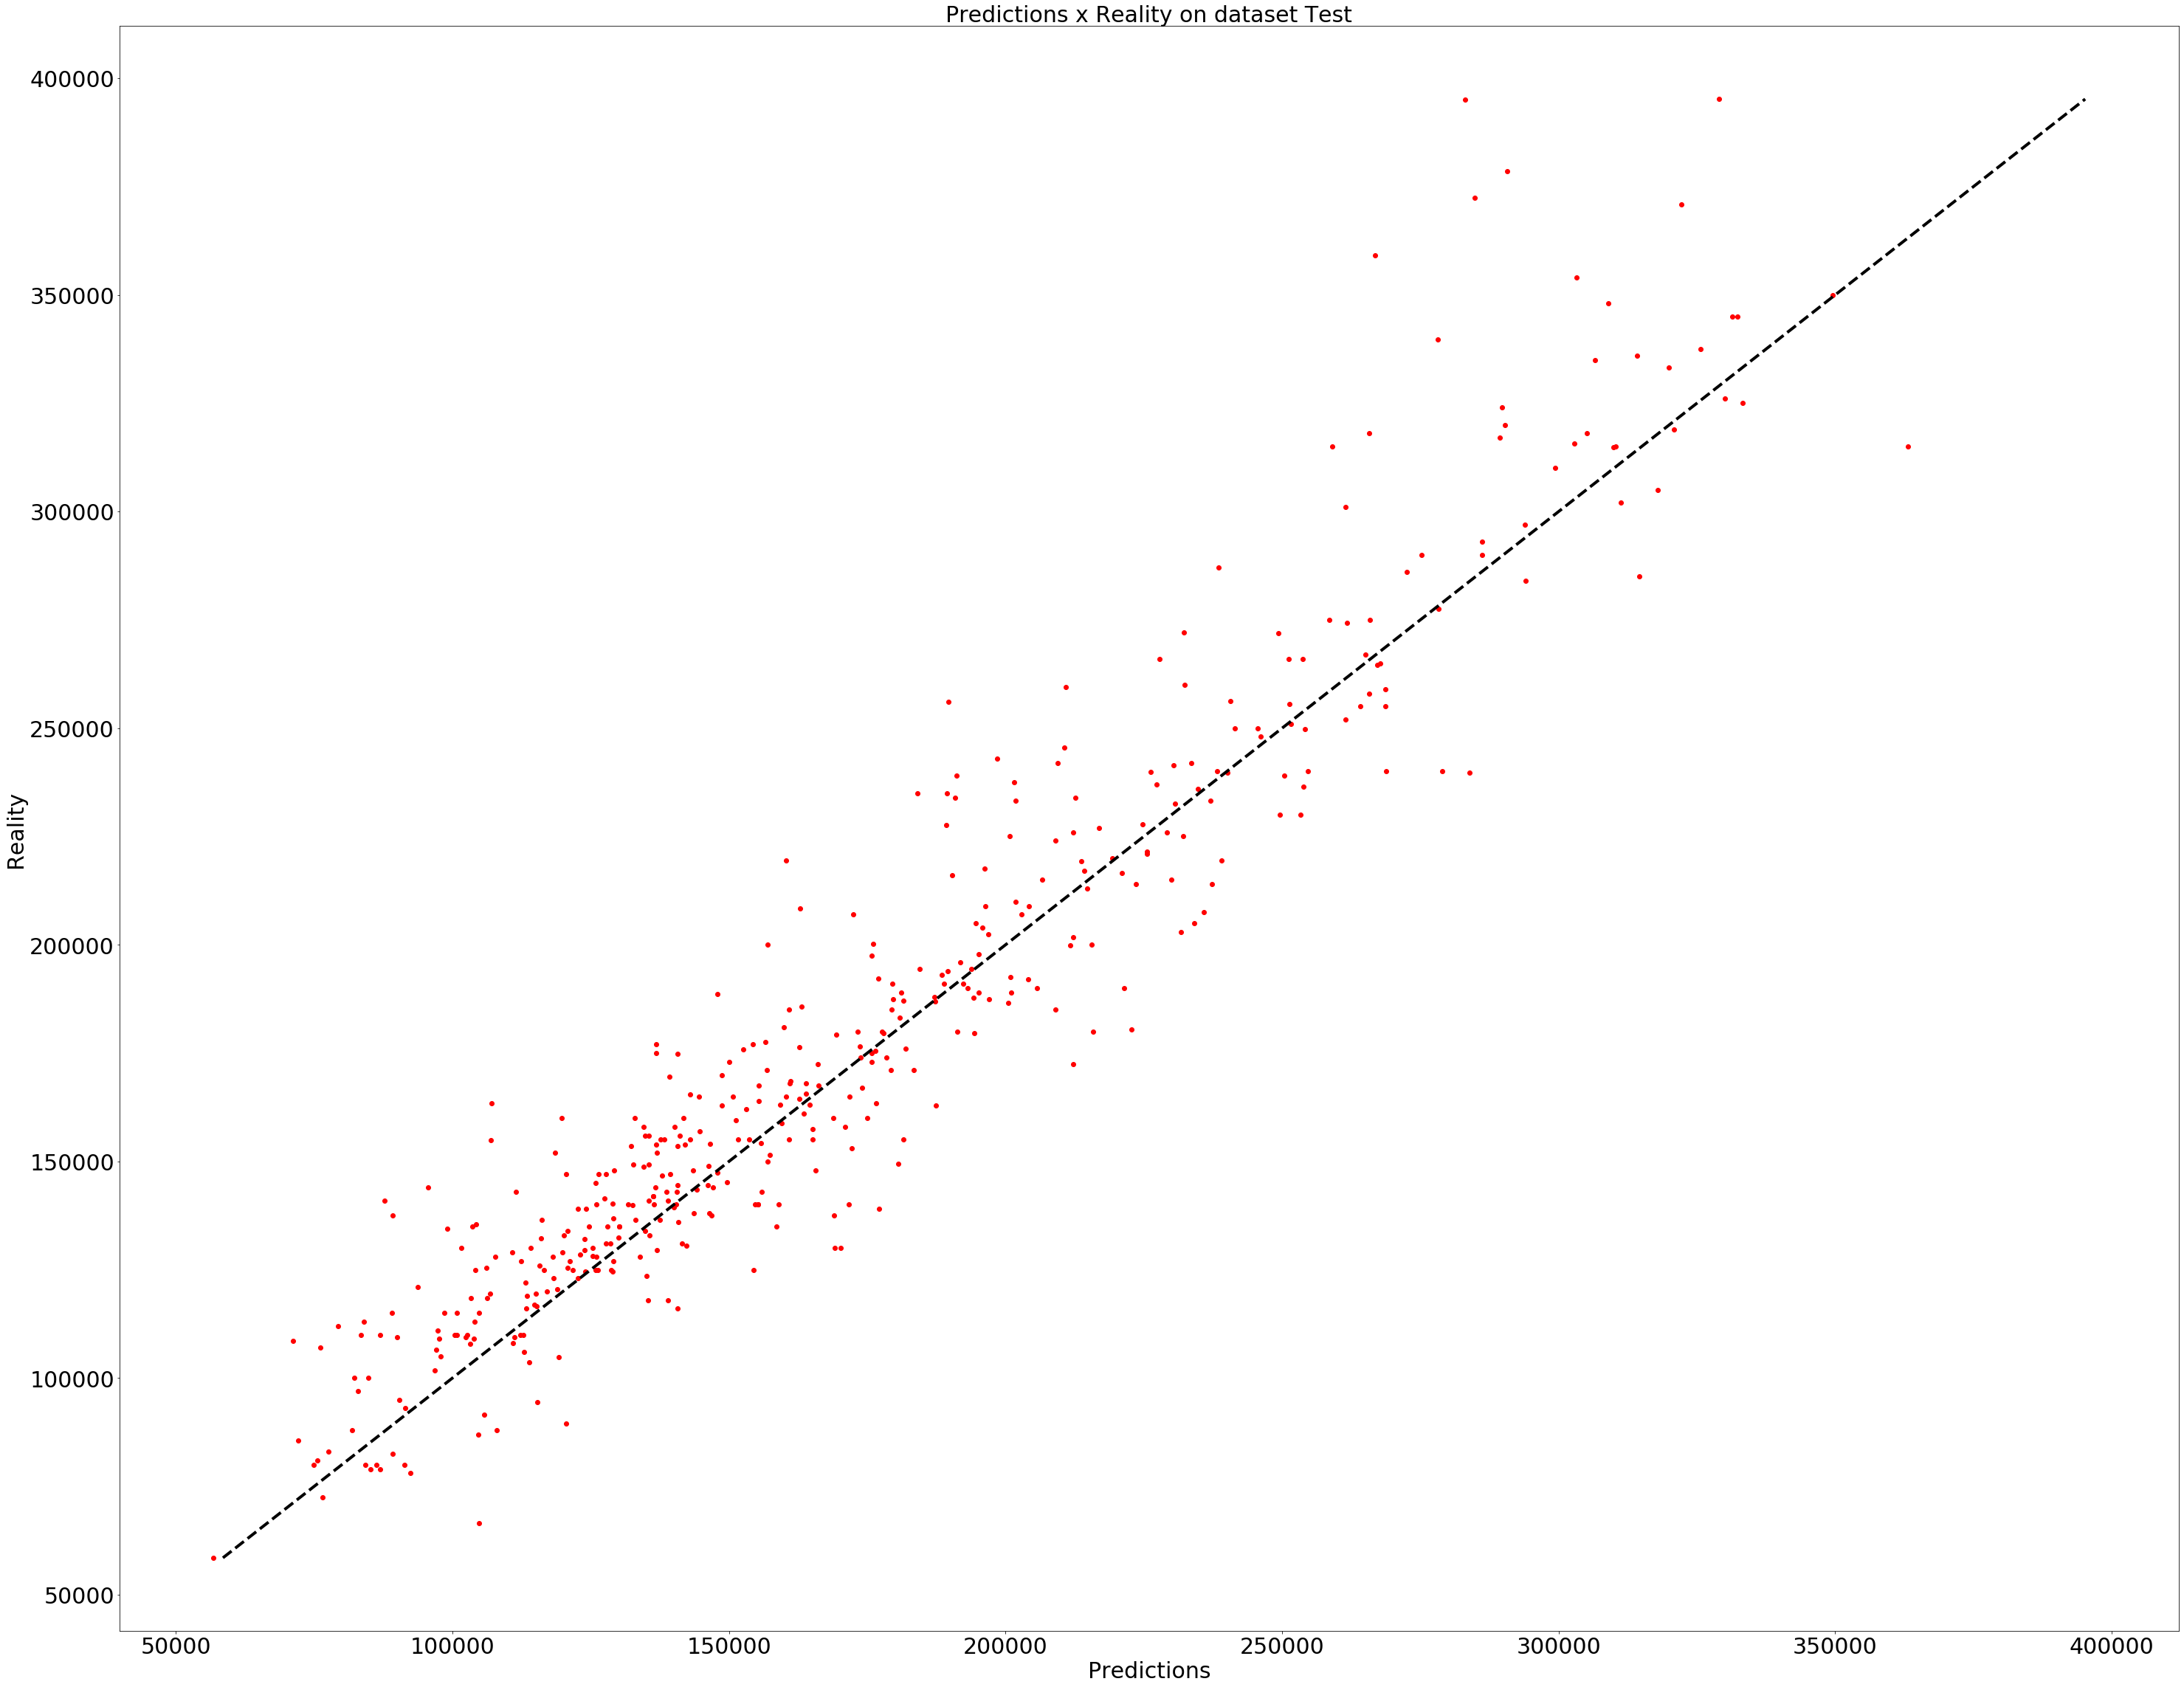

In [19]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40)) 

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')  # 画折线图，x为预测值，y为真实值
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4) # 画边框
plt.show()

In [20]:
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True)) # 使用dnn对测试集进行预测

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0])) # 创建迭代器
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['SalePrice']) # 反标准化
    y_predict = y_predict.join(ID) # 添加id列
    y_predict.to_csv(name_out + '.csv',index=False) # 保存预测结果
    
to_submit(y_predict, "submission_continuous")

In [21]:
def leaky_relu(x): # 定义损失函数
    return tf.nn.relu(x) - 0.01 * tf.nn.relu(-x)

In [22]:
# Model,创建dnn模型，损失函数为leay_relu
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = leaky_relu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
# 使用训练集进行模型训集(从训练集中分出来的)
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split，在测试集(从训练集中分出来的)上评估模型
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)


In [23]:
# Display the score on the testing set
# 0.002X in average
loss_score2 = ev["loss"]  # 获取评估的损失值
print("Final Loss on the testing set with Leaky Relu: {0:f}".format(loss_score2)) # 打印评估值

Final Loss on the testing set with Leaky Relu: 0.002415


In [24]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))  # 在测试集上进行预测
to_submit(y_predict, "Leaky_relu") # 保存预测结果

In [25]:
# Model 创建dnn模型，损失函数为elu
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.elu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000) # 训练

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1) # 评估

loss_score3 = ev["loss"] # 获取评估的损失值

In [26]:
print("Final Loss on the testing set with Elu: {0:f}".format(loss_score3)) # 打印损失值

Final Loss on the testing set with Elu: 0.002322


In [27]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True)) # 预测
to_submit(y_predict, "Elu") # 保存预测结果

In [29]:
"""
 使用数值特征和类别特征进行dnn训练
"""
# Import and split
train = pd.read_csv('./train.csv')    # 取训练集
train.drop('Id',axis = 1, inplace = True) # 删除id
train_numerical = train.select_dtypes(exclude=['object']) # 选取数值特征
train_numerical.fillna(0,inplace = True)  # 补0
train_categoric = train.select_dtypes(include=['object']) # 选取类别特征
train_categoric.fillna('NONE',inplace = True) # 补none
train = train_numerical.merge(train_categoric, left_index = True, right_index = True)  # 将数值特征和类别特征进行合并，使用左右df的行索引

test = pd.read_csv('./test.csv') # 取测试集
ID = test.Id # 取id列
test.drop('Id',axis = 1, inplace = True)  # 删除id
test_numerical = test.select_dtypes(exclude=['object']) # 选数值特征
test_numerical.fillna(0,inplace = True) # 补0
test_categoric = test.select_dtypes(include=['object']) # 选类别特征
test_categoric.fillna('NONE',inplace = True) # 补none
test = test_numerical.merge(test_categoric, left_index = True, right_index = True)  # 合并数值特征和类别特征，使用左右df的行索引

In [30]:
# Removie the outliers
from sklearn.ensemble import IsolationForest # 隔离森林

clf = IsolationForest(max_samples = 100, random_state = 42) # 创建隔离森林
clf.fit(train_numerical) # 隔离森林训练，使用数值特征
y_noano = clf.predict(train_numerical) # 隔离森林预测，使用数值特征
y_noano = pd.DataFrame(y_noano, columns = ['Top'])  # 构造df,使用隔离森林预测结果
y_noano[y_noano['Top'] == 1].index.values # 取正样本索引值

train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values] # 获取数值特征的正样本
train_numerical.reset_index(drop = True, inplace = True) # 重置索引

train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values] # 获取类别特征的正样本
train_categoric.reset_index(drop = True, inplace = True) # 重置索引

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values] # 获取训练数据中的正样本
train.reset_index(drop = True, inplace = True) # 重置索引

In [31]:
col_train_num = list(train_numerical.columns) # 数值特征列
col_train_num_bis = list(train_numerical.columns) # 数值特征列

col_train_cat = list(train_categoric.columns) # 类别特征列

col_train_num_bis.remove('SalePrice') # 从数值特征列中删除label

mat_train = np.matrix(train_numerical) # 构造矩阵，训练数据，数值特征
mat_test  = np.matrix(test_numerical) # 构造矩阵，测试数据，数值特征
mat_new = np.matrix(train_numerical.drop('SalePrice',axis = 1)) # 构造矩阵，训练数据，数值特征，去除label
mat_y = np.array(train.SalePrice) # label数组

prepro_y = MinMaxScaler() # 归一化
prepro_y.fit(mat_y.reshape(1314,1)) # 对label进行fit

prepro = MinMaxScaler() # 归一化
prepro.fit(mat_train) # 对训练矩阵进行fit

prepro_test = MinMaxScaler() # 归一化
prepro_test.fit(mat_new) # 对去除label后的训练矩阵进行fit

train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train) # 构造df,使用训练数据
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis) # 构造df,使用测试数据

In [32]:
train[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num) # 对训练数据进行归一化
test[col_train_num_bis]  = test_num_scale # 测试数据，未归一化

In [33]:
# List of features
COLUMNS = col_train_num # 训练数据列
FEATURES = col_train_num_bis # 训练数据列，去除label
LABEL = "SalePrice" # label

FEATURES_CAT = col_train_cat # 类别特征列

engineered_features = [] # 特征容器，用于存经过tf加工的特征列

for continuous_feature in FEATURES:
    engineered_features.append(
        tf.contrib.layers.real_valued_column(continuous_feature)) # 处理数值型特征

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.contrib.layers.sparse_column_with_hash_bucket(
        categorical_feature, hash_bucket_size=1000) # 处理类别特征，hash计算类别特征
    # 迅速把高维稀疏类别特征向量转为想要维数的嵌入向量
    engineered_features.append(tf.contrib.layers.embedding_column(sparse_id_column=sparse_column, dimension=16,combiner="sum"))
                                 
# Training set and Prediction set with the features to predict
training_set = train[FEATURES + FEATURES_CAT] # 数值特征+类别特征
prediction_set = train.SalePrice # label

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES + FEATURES_CAT] ,
                                                    prediction_set, test_size=0.33, random_state=42) # 分割训练集、测试集
y_train = pd.DataFrame(y_train, columns = [LABEL]) # 创建df,使用label
training_set = pd.DataFrame(x_train, columns = FEATURES + FEATURES_CAT).merge(y_train, left_index = True, right_index = True)
# 创建df,使用数值特征、类别特征、label
# Training for submission
training_sub = training_set[FEATURES + FEATURES_CAT] # 训练集数值特征+类别特征
testing_sub = test[FEATURES + FEATURES_CAT]     # 测试集数值特征+类别特征

In [34]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL]) # 创建df, 使用测试label，注意这里测试集是从训练集中分割出的
testing_set = pd.DataFrame(x_test, columns = FEATURES + FEATURES_CAT).merge(y_test, left_index = True, right_index = True) # 创建测试集df

In [35]:
training_set[FEATURES_CAT] = training_set[FEATURES_CAT].applymap(str) # 训练集类别特征转str
testing_set[FEATURES_CAT] = testing_set[FEATURES_CAT].applymap(str) # 测试集类别特征转str

def input_fn_new(data_set, training = True): # 训练集包装函数
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES} # 数值特征转成tf所需格式
    
    categorical_cols = {k: tf.SparseTensor(  # 稀疏张量函数，类别特征转成tf所需格式，n行1列，n为特征k的样本数
        indices=[[i, 0] for i in range(data_set[k].size)], values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}

    # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items())) # 合并数值特征和类别特征
    
    if training == True: # 训练时
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values) # 将label转成tf所需的格式

        # Returns the feature columns and the label.
        return feature_cols, label # 返回feature_cols， label
    
    return feature_cols # 预测时，返回feature_cols

# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12]) # 创建dnn回归模型

In [36]:
categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(training_set[k].size)], values = training_set[k].values, dense_shape = [training_set[k].size, 1]) for k in FEATURES_CAT}
# 在训练集上，使用类别特征稀疏张量函数

In [37]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000) # 在训练集上进行训练

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f1683e9a358>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(col

In [38]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1) # 在测试集(从训练集分出的)上进行模型评估

In [39]:
loss_score4 = ev["loss"] # 获取评估结果，损失函数值
print("Final Loss on the testing set: {0:f}".format(loss_score4)) # 打印评估结果

Final Loss on the testing set: 0.002077


In [40]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn_new(testing_set)) # 模型预测，在测试集上进行预测
predictions = list(itertools.islice(y, testing_set.shape[0]))  # 使预测结果可迭代，转成list
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(434,1))) # 反归一化

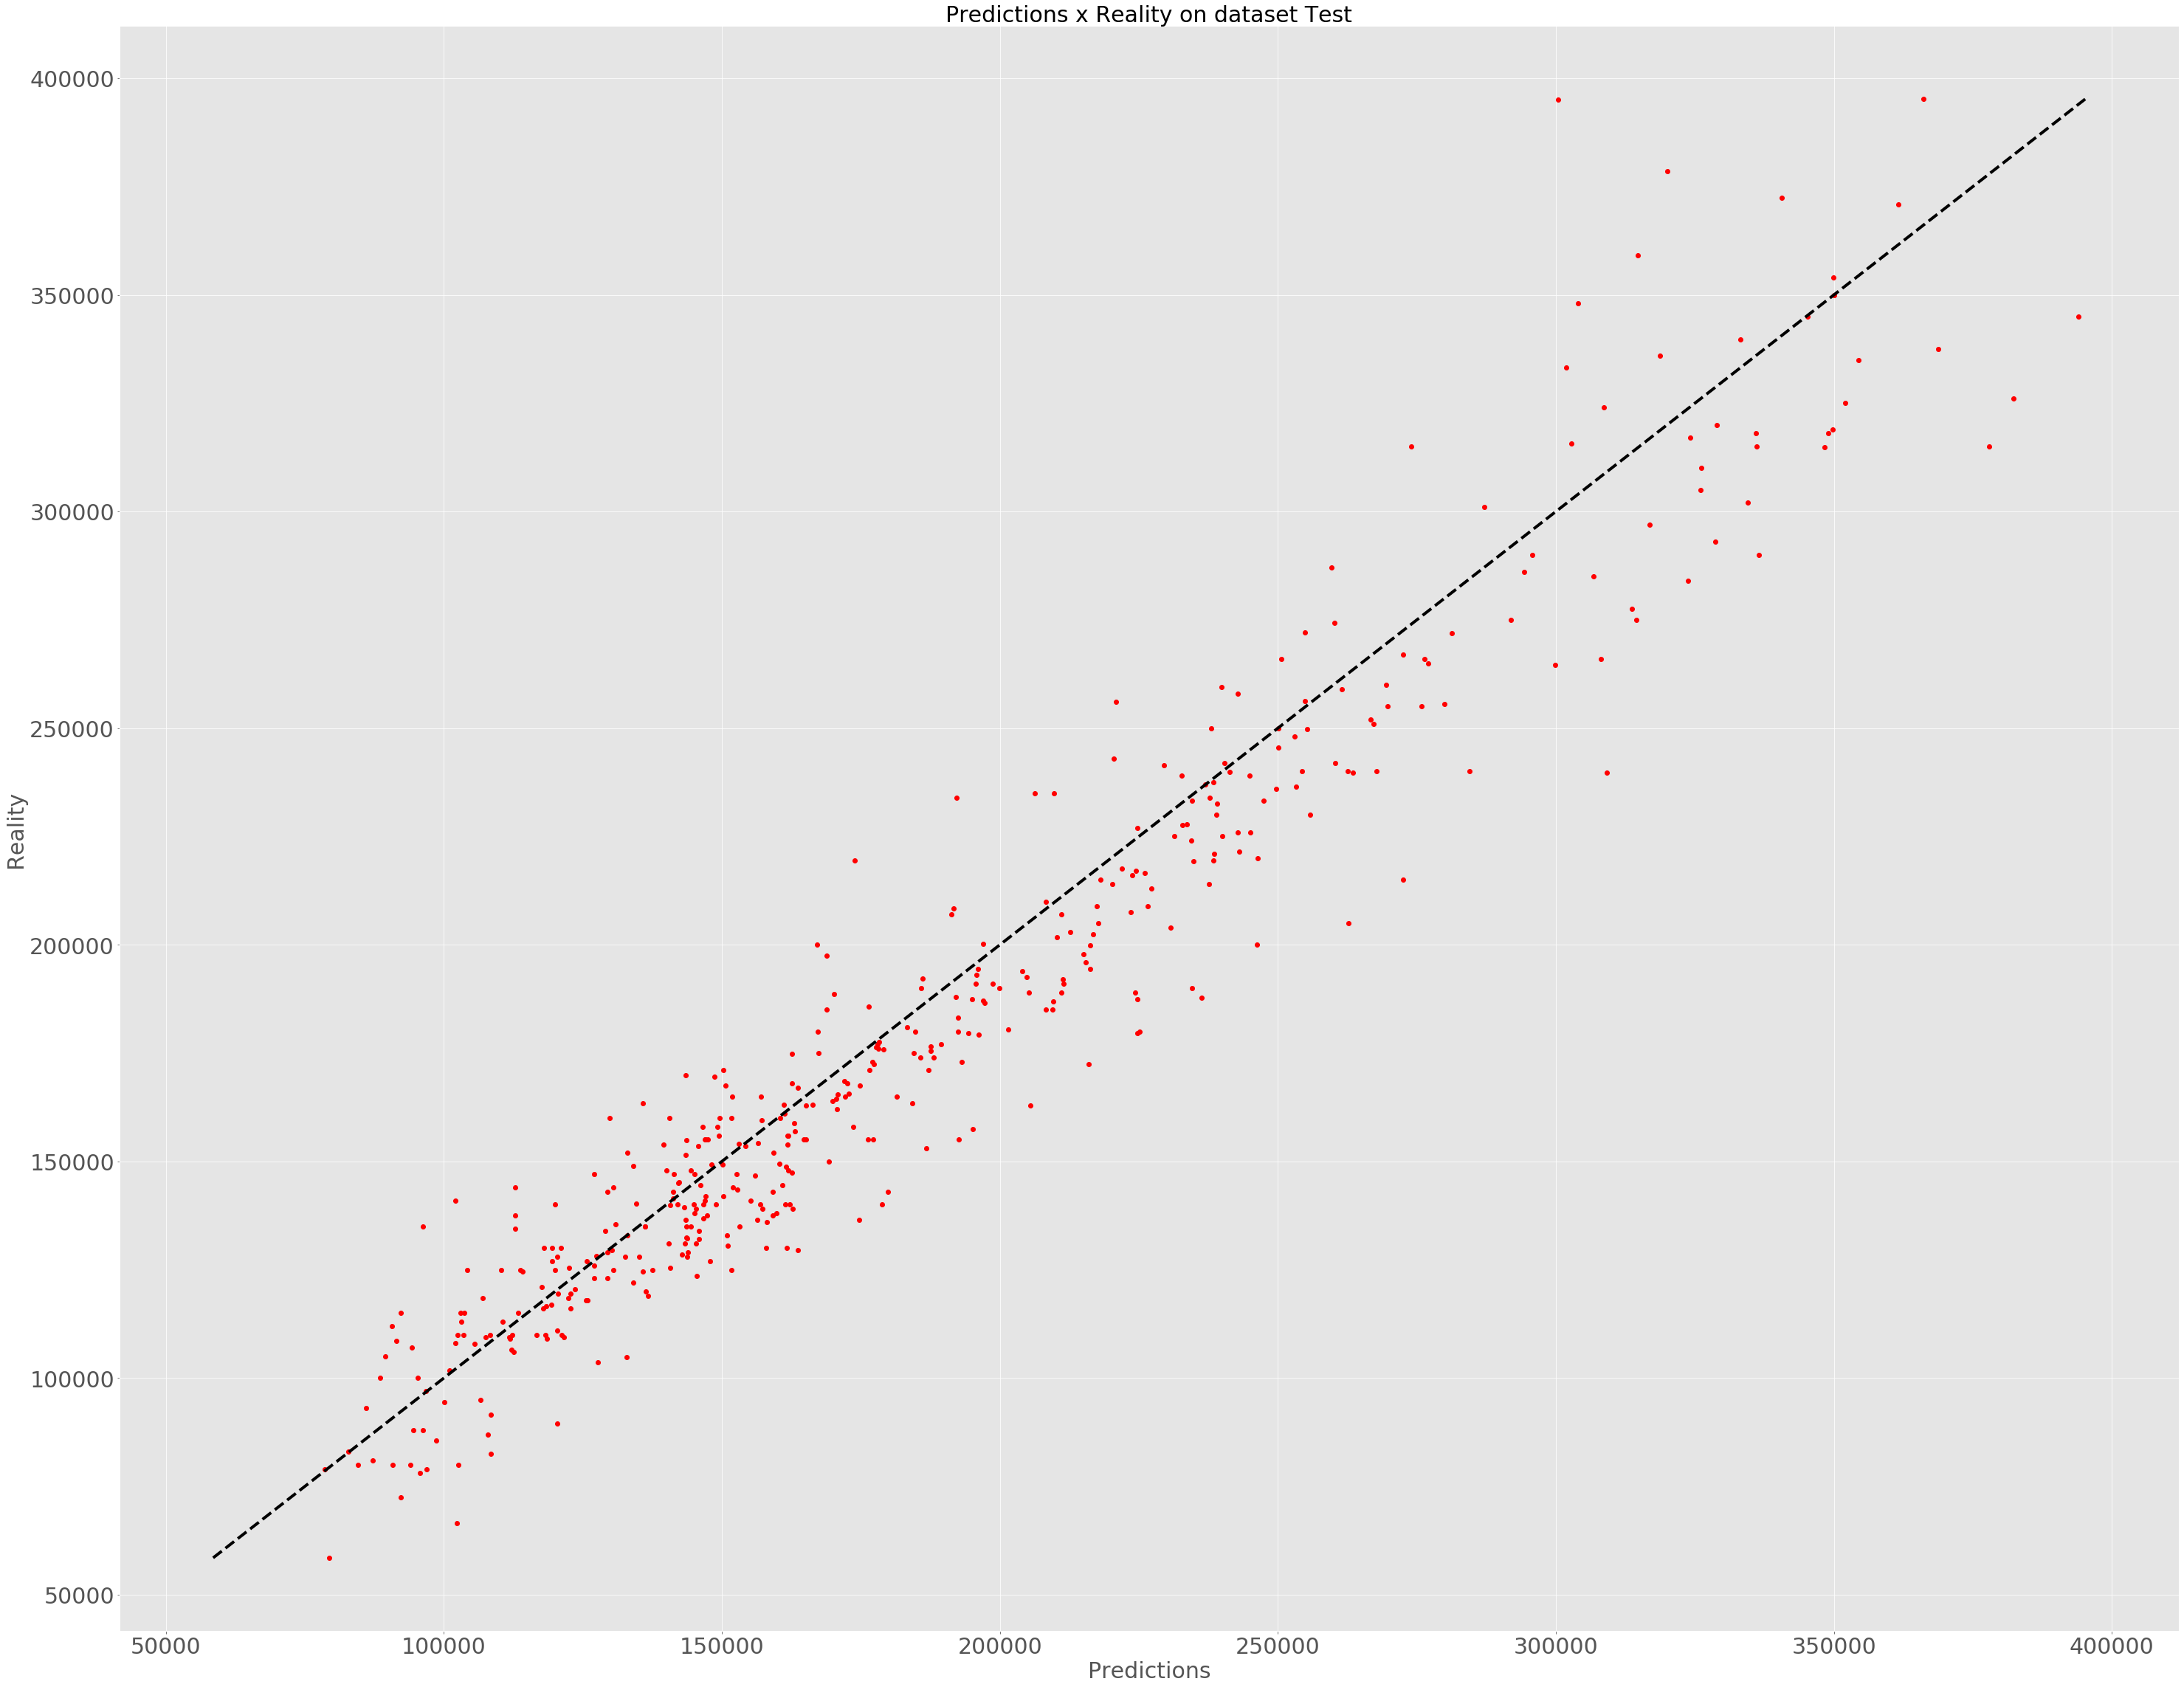

In [41]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro') # 使用预测值和真实值画图 
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4) # 画边框
plt.show()

In [42]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False)) # 在测试集上进行预测

In [43]:
to_submit(y_predict, "submission_cont_categ") # 保存预测结果

In [44]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[1000]) # 创建dnn,使用一层的神经网络

In [45]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000) # 模型训练


DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f1677e18780>, 'hidden_units': [1000], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='MasVnr

In [46]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1) # 模型评估
loss_score5 = ev["loss"] # 获取评估结果

In [47]:
print("Final Loss on the testing set: {0:f}".format(loss_score5)) # 打印评估结果

Final Loss on the testing set: 0.001748


In [48]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))    # 在测试集上进行预测
to_submit(y_predict, "submission_shallow") # 保存预测结果

In [49]:
list_score = [loss_score1, loss_score2, loss_score3, loss_score4,loss_score5] # 收集5个模型的评估结果
list_model = ['Relu_cont', 'LRelu_cont', 'Elu_cont', 'Relu_cont_categ','Shallow_1ku'] # 对应的5个模型

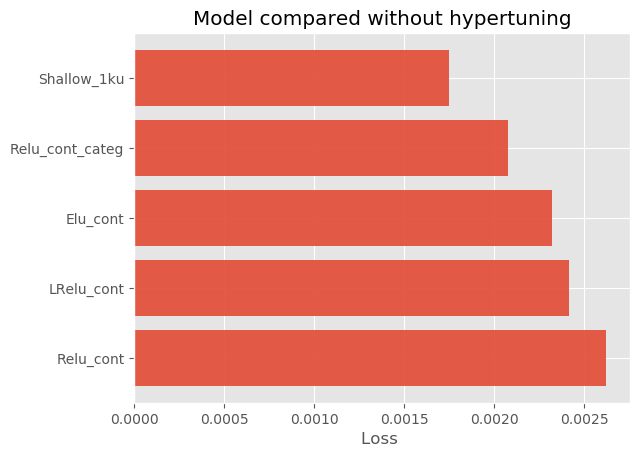

In [50]:
import matplotlib.pyplot as plt; plt.rcdefaults()

plt.style.use('ggplot')
objects = list_model
y_pos = np.arange(len(objects))
performance = list_score
 
plt.barh(y_pos, performance, align='center', alpha=0.9) # 画出5个模型评估结果对比图
plt.yticks(y_pos, objects)
plt.xlabel('Loss ')
plt.title('Model compared without hypertuning')
 
plt.show()